In [1]:
import stepwise_regression.step_reg as step_reg
from pyCompare import blandAltman

from scipy.stats import pearsonr, spearmanr
from scipy.special import logit

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

%matplotlib inline

In [2]:
file_suffix = "_after_shift_p150.csv"
# file_suffix = "_after_shift_stimulation_site.csv"

%run load_connectivity_data.ipynb

Couldn't load Patient #3 data using file suffix: _after_shift_p150.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p150.csv


In [3]:
patient_ids = [1, 4, 6, 7, 10, 11, 12]


In [4]:
macrostructural_conn_measures = [
    'streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist'
]

microstructural_conn_measures = [
    'mean_fa', 'mean_md', 'mean_ad', 'mean_rd', 
    'mean_rtop', 'mean_rtpp', 'mean_msd', 'mean_qiv', 'ng', 'ng_perp', 'ng_par'
]

effective_conn_measures = [
    'p1_delay', 'p1_value'
]

In [5]:
def get_patient_data_set(patient_id, structural_conn, effective_conn):

    data_set = data_pd[patient_id].loc[np.abs(data_pd[patient_id][effective_conn]) > 0]

    input_variables = data_set[structural_conn]
    
    if 'streamlines_num' in structural_conn:
        input_variables['streamlines_num'] = -np.log10(1 + data_set[['streamlines_num']])
    
    if 'mean_rtop' in structural_conn:
        input_variables['mean_rtop'] = np.power(np.maximum(0, data_set[['mean_rtop']]), 1.0/3)
        
    if 'mean_rtap' in structural_conn:
        input_variables['mean_rtap'] = np.power(np.maximum(0, data_set[['mean_rtap']]), 1.0/2)
    
    output_variable = data_set[[effective_conn]]
    
    return input_variables, output_variable


def modify_data_for_amplitude(input_variables, output_variable, structural_conn):

    inverse_values = ['streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist']
    
    for inverse_value in inverse_values:
        if inverse_value in structural_conn:
            input_variables[inverse_value] = 1.0 / (1 + input_variables[inverse_value])
            
    output_variable[['p1_value']] = np.sqrt(1e06 * np.abs(output_variable[['p1_value']]))

    return input_variables, output_variable 


def get_data_set(patient_ids, structural_conn, effective_conn = 'p1_delay'):

    input_variables_vector = []
    output_variable_vector = []
    
    for patient_id in patient_ids:
        x, y = get_patient_data_set(patient_id, structural_conn, effective_conn)
        
        if effective_conn == 'p1_value':
            x, y = modify_data_for_amplitude(x, y, structural_conn)
        
        input_variables_vector.append(x)
        output_variable_vector.append(y)
        
    return pd.concat(input_variables_vector), pd.concat(output_variable_vector)
        
    

In [6]:
def get_batch_patient_ids(patient_dataset_ids):

    batch_patient_ids = []

    for test_patient_id in patient_dataset_ids:
        train_patient_ids = patient_dataset_ids.copy()
        train_patient_ids.remove(test_patient_id)
        batch_patient_ids.append([train_patient_ids, [test_patient_id]])

    return batch_patient_ids


In [7]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [8]:
def get_squared_error(effective_var, test_y, pred_y):
    test_y = np.squeeze(test_y)
    pred_y = np.squeeze(pred_y)
    
    if effective_var == 'p1_delay':
        return (test_y - pred_y) ** 2
    
    elif effective_var == 'p1_value':
        return (test_y ** 2 - pred_y ** 2) ** 2
    

In [9]:
def prediction_summary(regr, patient_ids, macrostructural_var, microstructural_vars, effective_var):

    input_data_sets = [
        [macrostructural_var], 
        [macrostructural_var] + microstructural_vars,
    ]
    
    input_data_sets_labels = ['macro only', 'macro and micro', 'micro only']
    
    print(macrostructural_var.upper())

    for i in range(len(input_data_sets)):
        
        r2_scores = []
        squared_errors = []
        for batch in get_batch_patient_ids(patient_ids):
            
            train_x, train_y = get_data_set(batch[0], input_data_sets[i], effective_var)
            test_x, test_y = get_data_set(batch[1], input_data_sets[i], effective_var)

            regr.fit(train_x, train_y)
            pred_y = regr.predict(test_x)

            r2_scores.append(r2_score(np.squeeze(test_y.values), pred_y))
            
            squared_errors.extend(
                get_squared_error(effective_var, test_y.values, pred_y)
            )
            
#         print(r2_scores)
        print("%s\tR2 = %.2f +/- %.2f\tRMSE = %.0f +/- %.0f" % (
            input_data_sets_labels[i], 
            np.mean(r2_scores), np.std(r2_scores),
            np.sqrt(np.mean(squared_errors)), np.sqrt(np.std(squared_errors)),
        ))
        
        

In [10]:
def linear_prediction_summary(patient_ids, macrostructural_var, microstructural_vars, effective_var, stepwise = True):

    if stepwise:

        x, y = get_data_set(
            patient_ids, 
            [macrostructural_var] + microstructural_vars, 
            effective_var
        )
        input_data_sets = [
            [macrostructural_var], 
            step_reg.forward_regression(x, y, 0.05) # 0.25)
        ]
        print(input_data_sets)
    
    else:
    
        input_data_sets = [
            [macrostructural_var], [macrostructural_var] + microstructural_vars
        ]
        
    
    input_data_sets_labels = ['macrostructure only', 'macro- and microstructure', 'microstructure only']
    
    regr = linear_model.LinearRegression()
    print(macrostructural_var.upper())

    result = []    
    for i in range(len(input_data_sets)):
        
        r2_scores = []
        squared_errors = []

        all_pred_y = []
        all_test_y = []
        
        plt.figure(figsize=(7, 4))
        
        for batch in get_batch_patient_ids(patient_ids):
            
            train_x, train_y = get_data_set(batch[0], input_data_sets[i], effective_var)
            test_x, test_y = get_data_set(batch[1], input_data_sets[i], effective_var)

            regr.fit(train_x, train_y)
            pred_y = regr.predict(test_x)

            r2_scores.append(r2_score(np.squeeze(test_y.values), np.squeeze(pred_y)))
            squared_errors.extend(
                get_squared_error(effective_var, test_y.values, pred_y)
            )
            
            all_pred_y.extend(np.squeeze(pred_y))
            all_test_y.extend(np.squeeze(test_y.values))
            
        print(r2_scores)
        print("%s\tR2 = %.2f +/- %.2f\tRMSE = %.0f +/- %.0f" % (
            input_data_sets_labels[i], 
            np.mean(r2_scores), np.std(r2_scores),
            np.sqrt(np.mean(squared_errors)), np.sqrt(np.std(squared_errors)),
        ))
        
        result.append([
            np.mean(r2_scores), np.std(r2_scores),
            np.sqrt(np.mean(squared_errors)), np.sqrt(np.std(squared_errors)),
        ])
        
        # p1 delays
        bland_altman_plot(all_pred_y, all_test_y, color = "C0")
        plt.xlim([15, 60])
        plt.ylim([-30, 30])
        plt.ylabel("Pred. P1 delays $-$ Meas. P1 delays [ms]")
        plt.xlabel("(Predicted P1 delays $+$ Measured P1 delays) / 2 [ms]")

#         # p1 amplitudes
#         bland_altman_plot(np.array(all_pred_y) ** 2, np.array(all_test_y) ** 2, color = "C0")
#         plt.ylim([-1100, 800])
#         plt.ylabel("Pred. P1 ampl. $-$ Meas. P1 ampl. [µV]")
#         plt.xlabel("(Predicted P1 amplitudes $+$ Measured P1 amplitudes) / 2 [µV]")

        plt.savefig("%s batch.pdf" % (input_data_sets_labels[i]), bbox_inches = 'tight')
        plt.savefig("%s batch.eps" % (input_data_sets_labels[i]), bbox_inches = 'tight')
                
    return result


In [11]:
def fix_dim(data):

    data = np.array(data)
    if data.ndim < 2:
        data = data.reshape(-1, 1)
    return data


def intersubject_prediction_summary(patient_id, macrostructural_var, microstructural_vars, effective_var):
    
    kf = KFold(n_splits=2)
    
    input_data_sets = [
        [macrostructural_var], 
        [macrostructural_var] + microstructural_vars,
    ]

    for i in range(len(input_data_sets)):

        x, y = get_patient_data_set(patient_id, input_data_sets[i], effective_var)
        x = np.squeeze(x.values)
        y = np.squeeze(y.values)
        
        r2_scores = []
        for train_idx, test_idx in kf.split(x):
            train_x, test_x = fix_dim(x[train_idx]), fix_dim(x[test_idx])
            train_y, test_y = y[train_idx], y[test_idx]    

#             regr = ensemble.RandomForestRegressor()
#             regr = ensemble.GradientBoostingRegressor()
            regr = linear_model.LinearRegression()
#             regr = svm.SVR()

            regr.fit(train_x, train_y)
            pred_y = regr.predict(test_x)

            squared_error = (test_y - pred_y) ** 2

#             r2_scores.append(r2_score(train_y, regr.predict(train_x)))
            r2_scores.append(r2_score(test_y, pred_y))
    
#             if i == 0:
#                 plt.figure()
#                 bland_altman_plot(np.squeeze(pred_y), np.squeeze(test_y))
#                 plt.scatter(np.squeeze(train_x), train_y)
#                 plt.scatter(np.squeeze(test_x), test_y)
    
        print("#%02d\tR2 = %.2f +/- %.2f" % (patient_id, np.mean(r2_scores), np.std(r2_scores)))
        
    

In [12]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    print(macrostructural_conn_measure.upper())

    for patient_id in patient_ids:
        
        intersubject_prediction_summary(
            patient_id, 
            macrostructural_conn_measure, 
            ['ng'], 
            effective_conn_measures[0]
        )
        

# x, y = get_patient_data_set(patient_id, [macrostructural_conn_measures[1]], effective_conn_measures[0])

# np.squeeze(x.values)[[0, 1, 2]]

STREAMLINES_NUM
#01	R2 = 0.26 +/- 0.12
#01	R2 = 0.14 +/- 0.01
#04	R2 = 0.39 +/- 0.07
#04	R2 = 0.36 +/- 0.11
#06	R2 = 0.18 +/- 0.02
#06	R2 = 0.15 +/- 0.04
#07	R2 = 0.11 +/- 0.06
#07	R2 = -0.10 +/- 0.48
#10	R2 = 0.31 +/- 0.02
#10	R2 = -0.48 +/- 0.45
#11	R2 = -0.30 +/- 0.21
#11	R2 = -0.29 +/- 0.10
#12	R2 = 0.26 +/- 0.00
#12	R2 = 0.12 +/- 0.09
MIN_LEN
#01	R2 = 0.08 +/- 0.20
#01	R2 = -0.04 +/- 0.32
#04	R2 = 0.22 +/- 0.06
#04	R2 = 0.15 +/- 0.04
#06	R2 = 0.35 +/- 0.19
#06	R2 = 0.26 +/- 0.09
#07	R2 = 0.17 +/- 0.07
#07	R2 = 0.28 +/- 0.22
#10	R2 = 0.09 +/- 0.23
#10	R2 = -0.65 +/- 0.55
#11	R2 = -0.09 +/- 0.11
#11	R2 = -0.13 +/- 0.20
#12	R2 = 0.17 +/- 0.13
#12	R2 = 0.22 +/- 0.09
MEDIAN_LEN
#01	R2 = 0.02 +/- 0.08
#01	R2 = -0.42 +/- 0.33
#04	R2 = -1.08 +/- 0.22
#04	R2 = -4.08 +/- 2.96
#06	R2 = 0.07 +/- 0.03
#06	R2 = -0.04 +/- 0.03
#07	R2 = -1.01 +/- 0.37
#07	R2 = -0.77 +/- 0.28
#10	R2 = 0.13 +/- 0.07
#10	R2 = -2.54 +/- 0.59
#11	R2 = -0.38 +/- 0.21
#11	R2 = -0.04 +/- 0.10
#12	R2 = 0.08 +/- 0.06
#12	R

# Prediction of P1 delays

In [13]:
# regr = ensemble.RandomForestRegressor(random_state = 123)
regr = ensemble.GradientBoostingRegressor(random_state = 123)
# regr = svm.SVR()

for macrostructural_conn_measure in macrostructural_conn_measures:
    prediction_summary(
        regr, patient_ids,
        macrostructural_conn_measure, 
        microstructural_conn_measures,
        effective_conn_measures[0]
    )

STREAMLINES_NUM
macro only	R2 = -0.32 +/- 0.67	RMSE = 9 +/- 12
macro and micro	R2 = -0.20 +/- 0.43	RMSE = 9 +/- 10
MIN_LEN
macro only	R2 = -0.04 +/- 0.38	RMSE = 8 +/- 10
macro and micro	R2 = -0.10 +/- 0.48	RMSE = 8 +/- 10
MEDIAN_LEN
macro only	R2 = -1.12 +/- 1.79	RMSE = 11 +/- 15
macro and micro	R2 = -0.30 +/- 0.27	RMSE = 9 +/- 11
SMOOTHWM_SURF_DIST
macro only	R2 = -0.40 +/- 0.29	RMSE = 10 +/- 11
macro and micro	R2 = -0.33 +/- 0.29	RMSE = 9 +/- 11


[['streamlines_num'], ['streamlines_num', 'mean_msd']]
STREAMLINES_NUM
[-0.15436122931684082, 0.29752615904554036, 0.3074847874913391, 0.43174774638642344, 0.3431638201946934, -1.252929651966376, 0.2789923303374565]
macrostructure only	R2 = 0.04 +/- 0.55	RMSE = 8 +/- 10
[-0.09989818574237197, 0.35459198930078883, 0.3071266345487885, 0.3768593626084631, 0.3438489712019449, -0.9140292440803686, 0.26674745052860915]
macro- and microstructure	R2 = 0.09 +/- 0.44	RMSE = 8 +/- 10
[['min_len'], ['min_len', 'mean_msd', 'mean_fa', 'ng_perp', 'ng_par']]
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.1386308771858853, 0.16967450600512535, 0.3590308297641115, 0.1536176965572802, 0.3014126438445889, 0.21606946121787696, 0.41827702832998404]
macro- and microstructure	R2 = 0.21 +/- 0.17	RMSE = 7 +/- 9
[['median_len'], ['mean_fa', 'ng_perp', 

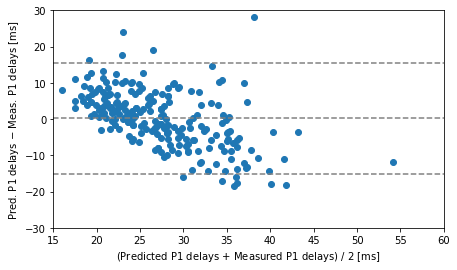

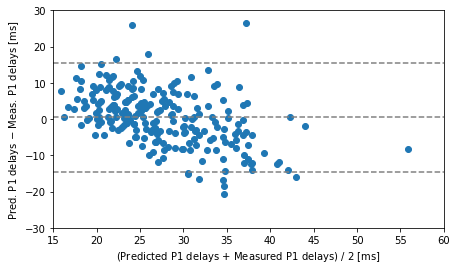

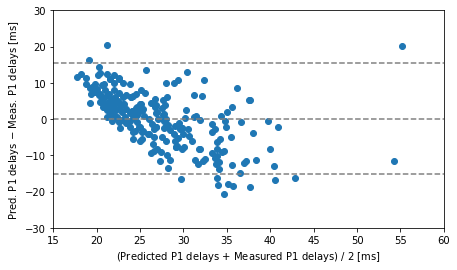

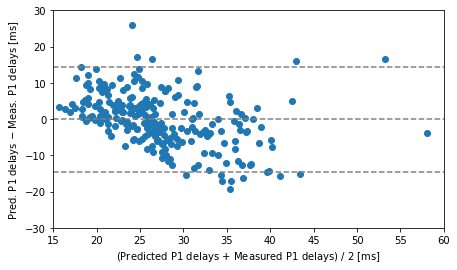

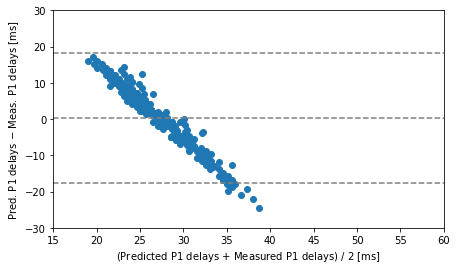

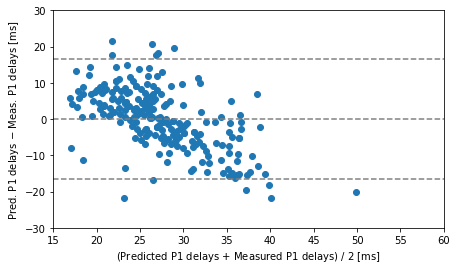

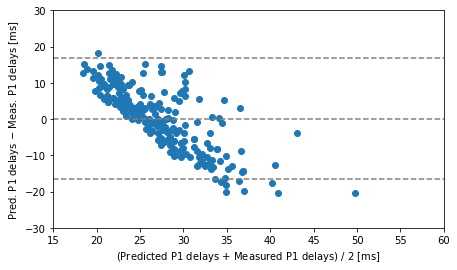

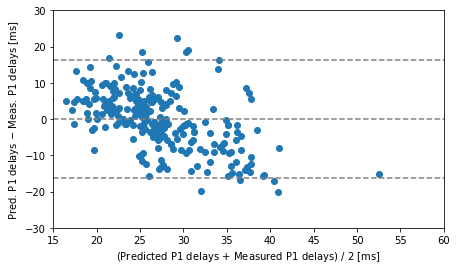

In [14]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    linear_prediction_summary(
        patient_ids,
        macrostructural_conn_measure, 
        microstructural_conn_measures,
        effective_conn_measures[0],
        stepwise=True
    )

# Prediction of P1 amplitudes

In [15]:
# regr = ensemble.RandomForestRegressor(random_state = 123)
# regr = ensemble.GradientBoostingRegressor(random_state = 123)
regr = svm.SVR()

for macrostructural_conn_measure in macrostructural_conn_measures:
    prediction_summary(
        regr, patient_ids,
        macrostructural_conn_measure, 
        microstructural_conn_measures,
        effective_conn_measures[1]
    )

STREAMLINES_NUM
macro only	R2 = -0.10 +/- 0.20	RMSE = 272 +/- 434
macro and micro	R2 = -0.16 +/- 0.18	RMSE = 274 +/- 434
MIN_LEN
macro only	R2 = 0.06 +/- 0.21	RMSE = 254 +/- 405
macro and micro	R2 = -0.16 +/- 0.19	RMSE = 274 +/- 434
MEDIAN_LEN
macro only	R2 = -0.12 +/- 0.19	RMSE = 273 +/- 435
macro and micro	R2 = -0.16 +/- 0.18	RMSE = 274 +/- 434
SMOOTHWM_SURF_DIST
macro only	R2 = -0.07 +/- 0.18	RMSE = 269 +/- 429
macro and micro	R2 = -0.16 +/- 0.18	RMSE = 274 +/- 434


[['streamlines_num'], ['streamlines_num', 'mean_fa']]
STREAMLINES_NUM
[0.1561991384955318, -0.14208676261423658, -0.07083131613169225, 0.08805638328808096, 0.27707837003906044, -0.034687061908420525, 0.12742975440993154]
macrostructure only	R2 = 0.06 +/- 0.14	RMSE = 240 +/- 384
[0.17677752435603156, -0.032578033744813384, -0.0341408420355398, 0.19611103314215184, 0.18346538155041148, 0.0489937860610864, 0.18696717575694366]
macro- and microstructure	R2 = 0.10 +/- 0.10	RMSE = 237 +/- 368
[['min_len'], ['min_len', 'mean_fa', 'ng_perp']]
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
macrostructure only	R2 = 0.06 +/- 0.18	RMSE = 243 +/- 370
[0.13993622372652004, -0.28389167976818075, 0.04429589929819333, 0.19355756988408568, 0.2549808969801669, 0.15588437233088404, 0.3331760332835061]
macro- and microstructure	R2 = 0.12 +/- 0.19	RMSE = 236 +/- 356
[['median_len'], ['mean_fa', 

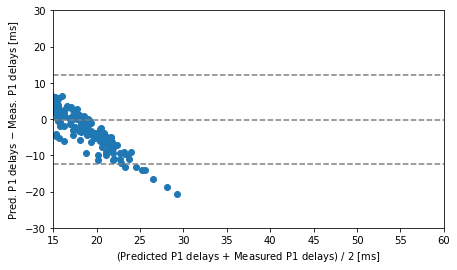

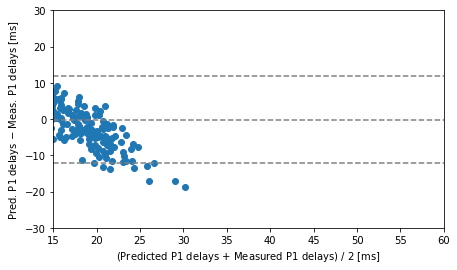

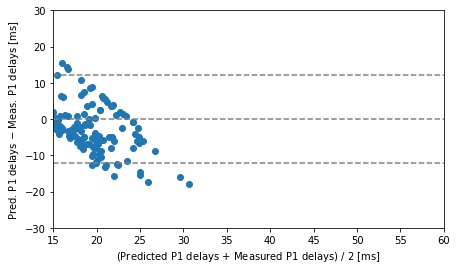

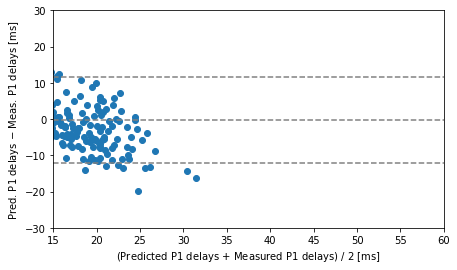

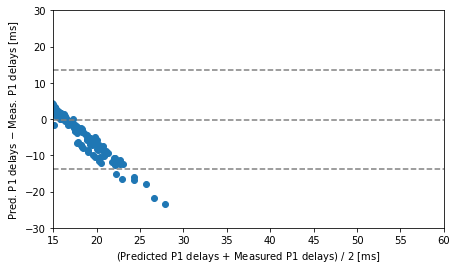

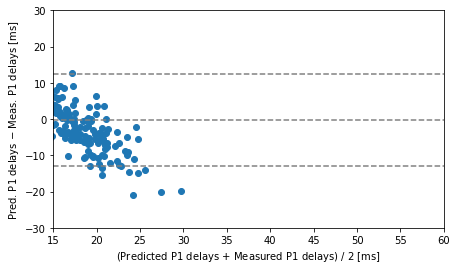

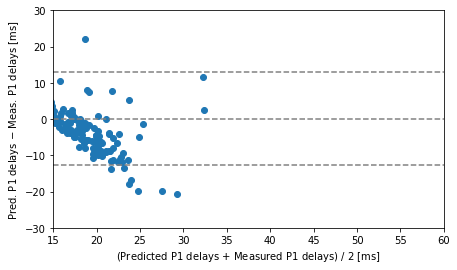

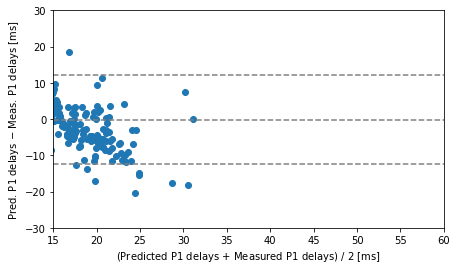

In [16]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    linear_prediction_summary(
        patient_ids,
        macrostructural_conn_measure, 
        microstructural_conn_measures,
        effective_conn_measures[1]
    )

# Prediction accuracy for P1 delays

Couldn't load Patient #3 data using file suffix: _after_shift_p10.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p10.csv
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.49837977168635006, 0.22189487019319865, 0.2300010615897724, 0.4295442472038111, 0.17870214631779924, 0.07398521375245681, -0.011823593643761843]
macro- and microstructure	R2 = 0.09 +/- 0.27	RMSE = 8 +/- 9
Couldn't load Patient #3 data using file suffix: _after_shift_p20.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p20.csv
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.373349033396841, 0.2242880686383203, 0.3041120865435738, 0.4218259673339657, 0.1539901531531009

Couldn't load Patient #3 data using file suffix: _after_shift_p160.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p160.csv
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.21688142972987623, 0.22253313464195656, 0.2868023456823666, 0.2164543965559751, 0.26980606668591856, 0.17592370647758937, 0.3473193790180755]
macro- and microstructure	R2 = 0.19 +/- 0.17	RMSE = 7 +/- 9
Couldn't load Patient #3 data using file suffix: _after_shift_p170.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p170.csv
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.23950196480391028, 0.21509521218040828, 0.26923314219439665, 0.22995505050465237, 0.2685926749

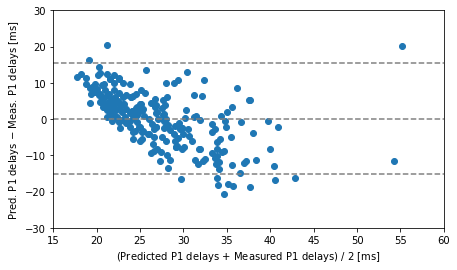

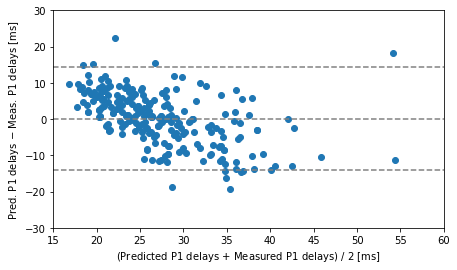

In [17]:
results = {}
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

for percentile in percentiles:

    file_suffix = "_after_shift_p%02d.csv" % percentile
    %run load_connectivity_data.ipynb
    
    results[percentile] = linear_prediction_summary(
        patient_ids, 'min_len', 
        ['mean_fa', 'ng_perp', 'mean_qiv', 'mean_rtpp'],
        effective_conn_measures[0],
        stepwise = False
    )    

file_suffix = "_after_shift_stimulation_site.csv"
%run load_connectivity_data.ipynb

results['site'] = linear_prediction_summary(
    patient_ids, 'min_len',
    microstructural_conn_measures,
    effective_conn_measures[0],
    stepwise = True
)    
    

In [18]:
data = [results[percentiles[0]][0]]

for percentile in percentiles:
    data.append(results[percentile][1])

# data.append(results['site'][1])    

data = np.array(data)

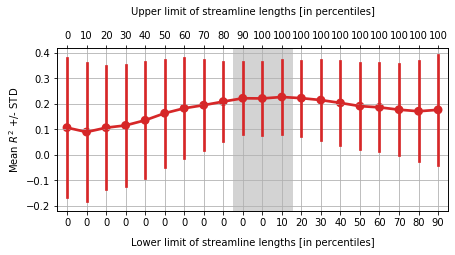

In [19]:
fig = plt.figure(figsize=(7, 3))

ax1 = fig.add_subplot(111)

# plt.plot([8.5, 8.5], [-1, 1], color="black", linestyle="dashed")
# plt.plot([11.5, 11.5], [-1, 1], color="black", linestyle="dashed")

plt.fill_between([8.5, 11.5], -1, 1, color="lightgray")

sns.pointplot(
    data = np.array([data[:, 0], data[:, 0] - data[:, 1], data[:, 0] + data[:, 1]]),
    ci = 100, color="C3"
)
plt.xticks(np.arange(0, len(percentiles) + 1), np.array(np.maximum(100, [0] + percentiles)) - 100)
plt.xlabel("Lower limit of streamline lengths [in percentiles]", labelpad=10)
plt.ylabel("Mean $R^2$ +/- STD")
plt.grid(True)

plt.ylim([-0.22, 0.42])


ax2 = ax1.twiny()
ax2.set_xlim([0, len(percentiles) + 1])
ax2.set_xticks(0.5 + np.arange(0, len(percentiles) + 1))
ax2.set_xticklabels(np.minimum(100, [0] + percentiles))
ax2.set_xlabel("Upper limit of streamline lengths [in percentiles]", labelpad=16)

plt.savefig("p1_delay_prediction_r2.pdf", bbox_inches = 'tight')
plt.savefig("p1_delay_prediction_r2.eps", bbox_inches = 'tight')

# plt.savefig("p1_amplitude_prediction_r2.pdf", bbox_inches = 'tight')
# plt.savefig("p1_amplitude_prediction_r2.eps", bbox_inches = 'tight')



Couldn't load Patient #3 data using file suffix: _after_shift_p100.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p100.csv
MIN_LEN
[-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
macrostructure only	R2 = 0.11 +/- 0.27	RMSE = 8 +/- 9
[-0.10789551875897496, 0.24528954213211085, 0.27876076882000933, 0.3558765177860189, 0.22895688999831199, 0.22158835830842583, 0.3238637772837545]
macro- and microstructure	R2 = 0.22 +/- 0.14	RMSE = 7 +/- 9


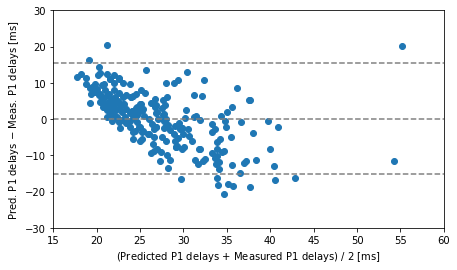

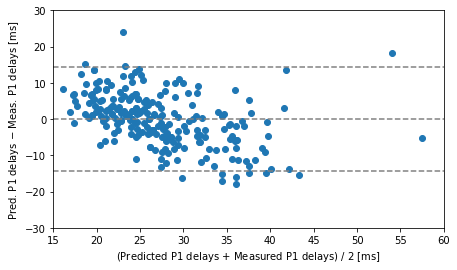

In [20]:
results = {}
percentiles = [100] # [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for percentile in percentiles:

    file_suffix = "_after_shift_p%02d.csv" % percentile
    %run load_connectivity_data.ipynb
    
    results[percentile] = linear_prediction_summary(
        patient_ids, 'min_len', 
        ['mean_fa', 'ng_perp', 'mean_qiv', 'mean_rtpp'],
        effective_conn_measures[0],
        stepwise = False
    )    

# file_suffix = "_after_shift_stimulation_site.csv"
# %run load_connectivity_data.ipynb

# results['site'] = linear_prediction_summary(
#     patient_ids, 'min_len',
#     microstructural_conn_measures,
#     effective_conn_measures[0],
#     stepwise = True
# )    
    

In [27]:
from scipy import stats

r2_macro_only = [-0.439822717928672, 0.13669162597677076, 0.3621094899710873, 0.4579300471071568, 0.2092946925006438, -0.0480023948430186, 0.06671135150913099]
r2_macro_and_micro = [-0.10789551875897496, 0.24528954213211085, 0.27876076882000933, 0.3558765177860189, 0.22895688999831199, 0.22158835830842583, 0.3238637772837545]

stats.ttest_rel(r2_macro_only, r2_macro_and_micro)

Ttest_relResult(statistic=-1.7171954953086532, pvalue=0.13675326451091596)

# Prediction accuracy for P1 amplitudes

Couldn't load Patient #3 data using file suffix: _after_shift_p10.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p10.csv
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
macrostructure only	R2 = 0.06 +/- 0.18	RMSE = 243 +/- 370
[0.06115362424573112, -0.24408946384863772, -0.6927362941038415, 0.023407192411887934, 0.3212776423554856, 0.15678974576478133, 0.24433151017993981]
macro- and microstructure	R2 = -0.02 +/- 0.32	RMSE = 251 +/- 378
Couldn't load Patient #3 data using file suffix: _after_shift_p20.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p20.csv
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
macrostructure only	R2 = 0.06 +/- 0.18	RMSE = 243 +/- 370
[0.059226398890936394, -0.25416683278660623, -0.7263839974796735, 0.

[0.13993622372652004, -0.28389167976818075, 0.04429589929819333, 0.19355756988408568, 0.2549808969801669, 0.15588437233088404, 0.3331760332835061]
macro- and microstructure	R2 = 0.12 +/- 0.19	RMSE = 236 +/- 356
Couldn't load Patient #3 data using file suffix: _after_shift_p160.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p160.csv
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
macrostructure only	R2 = 0.06 +/- 0.18	RMSE = 243 +/- 370
[0.11203128360414827, -0.2589053221432407, 0.022178476322256557, 0.2115960712429844, 0.26545154693777784, 0.1424901435607313, 0.3337978663626565]
macro- and microstructure	R2 = 0.12 +/- 0.18	RMSE = 237 +/- 356
Couldn't load Patient #3 data using file suffix: _after_shift_p170.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p170.csv
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -

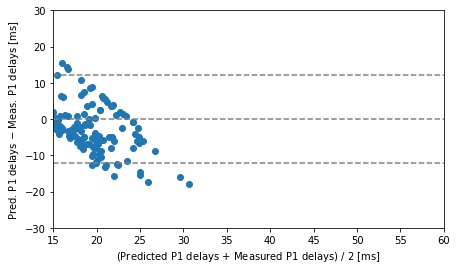

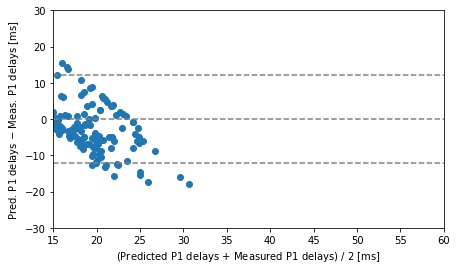

In [21]:
results = {}
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

for percentile in percentiles:

    file_suffix = "_after_shift_p%02d.csv" % percentile
    %run load_connectivity_data.ipynb
    
    results[percentile] = linear_prediction_summary(
        patient_ids, 'min_len', 
        ['mean_fa', 'ng_perp'],
        effective_conn_measures[1],
        stepwise = False
    )    

file_suffix = "_after_shift_stimulation_site.csv"
%run load_connectivity_data.ipynb

results['site'] = linear_prediction_summary(
    patient_ids, 'min_len',
    microstructural_conn_measures,
    effective_conn_measures[1],
    stepwise = True
)    
    

In [22]:
data = [results[percentiles[0]][0]]

for percentile in percentiles:
    data.append(results[percentile][1])

# data.append(results['site'][1])    

data = np.array(data)

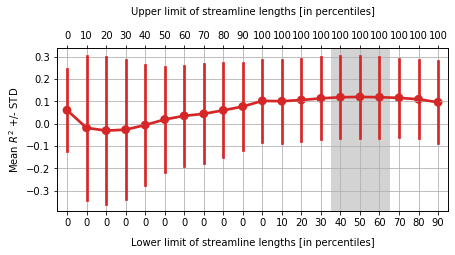

In [23]:
fig = plt.figure(figsize=(7, 3))

ax1 = fig.add_subplot(111)

# plt.plot([8.5, 8.5], [-1, 1], color="black", linestyle="dashed")
# plt.plot([11.5, 11.5], [-1, 1], color="black", linestyle="dashed")

plt.fill_between([13.5, 16.5], -1, 1, color="lightgray")

sns.pointplot(
    data = np.array([data[:, 0], data[:, 0] - data[:, 1], data[:, 0] + data[:, 1]]),
    ci = 100, color="C3"
)
plt.xticks(np.arange(0, len(percentiles) + 1), np.array(np.maximum(100, [0] + percentiles)) - 100)
plt.xlabel("Lower limit of streamline lengths [in percentiles]", labelpad=10)
plt.ylabel("Mean $R^2$ +/- STD")
plt.grid(True)

plt.ylim([-0.39, 0.34])


ax2 = ax1.twiny()
ax2.set_xlim([0, len(percentiles) + 1])
ax2.set_xticks(0.5 + np.arange(0, len(percentiles) + 1))
ax2.set_xticklabels(np.minimum(100, [0] + percentiles))
ax2.set_xlabel("Upper limit of streamline lengths [in percentiles]", labelpad=16)

plt.savefig("p1_amplitude_prediction_r2.pdf", bbox_inches = 'tight')
plt.savefig("p1_amplitude_prediction_r2.eps", bbox_inches = 'tight')



Couldn't load Patient #3 data using file suffix: _after_shift_p150.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p150.csv
MIN_LEN
[0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
macrostructure only	R2 = 0.06 +/- 0.18	RMSE = 243 +/- 370
[0.13993622372652004, -0.28389167976818075, 0.04429589929819333, 0.19355756988408568, 0.2549808969801669, 0.15588437233088404, 0.3331760332835061]
macro- and microstructure	R2 = 0.12 +/- 0.19	RMSE = 236 +/- 356


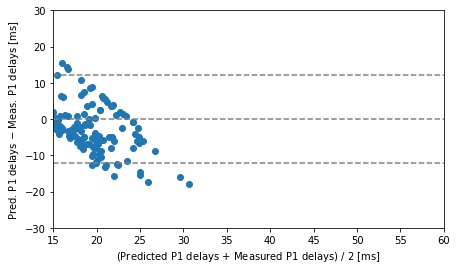

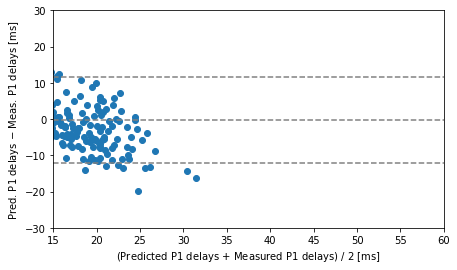

In [24]:
results = {}
percentiles = [150] 

for percentile in percentiles:

    file_suffix = "_after_shift_p%02d.csv" % percentile
    %run load_connectivity_data.ipynb
    
    results[percentile] = linear_prediction_summary(
        patient_ids, 'min_len', 
        ['mean_fa', 'ng_perp'],
        effective_conn_measures[1],
        stepwise = False
    )    


In [30]:
from scipy import stats

r2_macro_only = [0.033928277145848895, -0.16346992449335795, -0.18766489797042296, -0.0011492713656560127, 0.3344517904206227, 0.14651611935757192, 0.25914763357947246]
r2_macro_and_micro = [0.13993622372652004, -0.28389167976818075, 0.04429589929819333, 0.19355756988408568, 0.2549808969801669, 0.15588437233088404, 0.3331760332835061]

stats.ttest_rel(r2_macro_only, r2_macro_and_micro)

Ttest_relResult(statistic=-1.1913809864539324, pvalue=0.27848978179989925)